# Split the Rydberg Hamiltonian into block-diagonal matrices

In [1]:
from pathlib import Path

In [2]:
import qutip
import numpy as np
import matplotlib.pylab as plt
import scipy.sparse

In [3]:
from src.qdyn.io import read_indexed_matrix
from src.qdyn.model import LevelModel
from src.qdyn.pulse import Pulse
from src.plots import show_spy, plot_population
from src.blocksplitting import split_AB

In [4]:
%matplotlib inline

In [5]:
V_per_cm = 1.0 / 5.14220624463189208e09

In [6]:
# 1-based indices of the initial and target states
N_INITIAL = 1423
N_TARGET = 2696
# size of Hilbert space
N_HILBERT = N_TARGET

In [7]:
def rydberg_hamiltonian(
    H_drift_file,
    H_sigma_file,
    H_pi_file,
    F_DC,
    Omega_sigma,
):
    """Construct the time-dependent Hamiltonian

    Args:
        H_drift_file (str)
        H_sigma_file (str)
        H_pi_file (str)
        F_DC (float)
        Omega_sig (Pulse)
        exapnd_H_sigma (bool)
    """
    H_drift = qutip.Qobj(
        read_indexed_matrix(
            H_drift_file, shape=(N_HILBERT, N_HILBERT), expand_hermitian=False
        )
    )
    H_sigma = qutip.Qobj(
        read_indexed_matrix(
            H_sigma_file,
            shape=(N_HILBERT, N_HILBERT),
            expand_hermitian=False,
        )
    )
    H_pi = qutip.Qobj(
        read_indexed_matrix(
            H_pi_file, shape=(N_HILBERT, N_HILBERT), expand_hermitian=False
        )
    )
    H_0 = H_drift + F_DC * H_pi
    return [H_0, [H_sigma, Omega_sigma], [H_sigma.dag(), Omega_sigma]]

In [8]:
H = rydberg_hamiltonian(
    'data/ham_drift.dat',
    'data/ham_sig.dat',
    'data/ham_pi.dat',
    F_DC=2.5 * V_per_cm,
    Omega_sigma=Pulse.read('./data/pulse_sig.dat')
)

In [9]:
psi0 = qutip.ket([N_INITIAL-1], dim=H[0].shape[0])
psi_target = qutip.ket([N_TARGET-1], dim=H[0].shape[0])

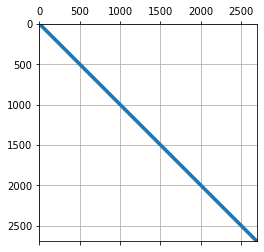

In [10]:
show_spy(H[0].data, show_diagonal=False, grid=True)

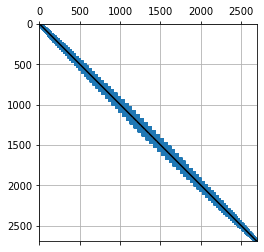

In [11]:
show_spy((H[1][0].data + H[2][0].data), show_diagonal=True, grid=True)

In [12]:
A, B = split_AB(
    H[1][0].data,
    block_info=np.genfromtxt("./data/n_states_red_block.dat", dtype=np.int32),
    n=N_HILBERT,
)

In [13]:
A, B = qutip.Qobj(A), qutip.Qobj(B)

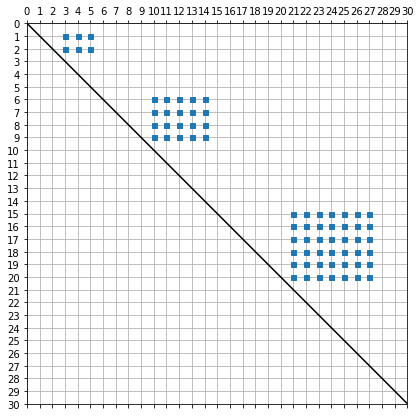

In [14]:
show_spy(
    A,
    figsize=(7, 7),
    show_diagonal=True,
    grid=True,
    xlim=(0, 30),
    ylim=(30, 0),
    label_pixels=True,
    markersize=5,
)

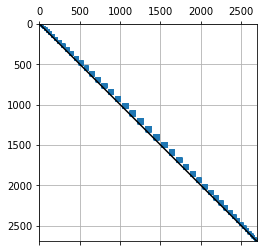

In [15]:
show_spy(B, show_diagonal=True, grid=True)

In [16]:
qdyn_model = LevelModel()

In [17]:
qdyn_model.add_ham(H[0], op_unit='au', op_type='pot')

In [18]:
qdyn_model.add_ham(A, pulse=H[1][1], op_unit='au', op_type='dip')

In [19]:
qdyn_model.add_ham(B, pulse=H[1][1], op_unit='au', op_type='dip')

In [20]:
qdyn_model.add_ham(A.dag(), pulse=H[1][1], op_unit='au', op_type='dip', conjg_pulse=True)

In [21]:
qdyn_model.add_ham(B.dag(), pulse=H[1][1], op_unit='au', op_type='dip', conjg_pulse=True)

In [22]:
qdyn_model.add_state(psi0, label='initial')

In [23]:
qdyn_model.add_state(psi_target, label='target')

In [24]:
qdyn_model.add_observable(
    qutip.ket2dm(psi0),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='initial',
)
qdyn_model.add_observable(
    qutip.ket2dm(psi_target),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='target',
)

In [25]:
qdyn_model.set_propagation(
    T=H[1][1].T,
    nt=len(H[1][1].states_tgrid),
    time_unit=H[1][1].time_unit,
)

In [26]:
RF = './rf_AB_prop'

In [27]:
qdyn_model.write_to_runfolder(RF)

In [28]:
%%bash -s "$RF"
qdyn_prop_traj --version
time qdyn_prop_traj --state-label=initial $1

QDYN 2.0dev revision 92024cace7e6b85565d01814a0de5f5cc9ae8167 (master)
  features: no-check-cheby, no-check-newton, no-parallel-ham, use-mkl=sequential, parallel-oct, backtraces, no-debug, no-no-ipo
  compiled with ifort on Sun Aug 18 18:25:27 2019 on host katamon
***** START OF PROGRAM qdyn_prop_traj ******
Tue Aug 20 20:50:31 +0200 2019

*** Read config file ./rf_AB_prop/config ***
*** Done reading config file ***
*** Initializing system ***
  *** Initializing grid ***
  No explicit grid found in config file! Initializing grid as one dimensional 1x1 fake grid
    Initializing grid as 1D cartesian grid without mapping
      Number of grid points was set to nr = 1 for dimension dim = 1! Initializing dimension 1 as a 1x1 fake-grid...
  *** Initializing pulses ***
    1 pulses in config file
    Initializing pulse 1
  *** Initializing dynamical generator ***
*** Done with initialization ***

Completed traj 1/1 in proc 1/1
Writing avg in proc 1/1

Tue Aug 20 20:53:29 +0200 2019
***** END 

1

real	2m57.628s
user	2m57.491s
sys	0m0.136s


In [29]:
pop_data = np.genfromtxt((Path(RF) / 'population.dat')).transpose()

In [30]:
pop_data_baseline = np.genfromtxt('./rf_baseline/population.dat').transpose()

/home/goerz/rydberg_parallelization/.venv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/goerz/rydberg_parallelization/.venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


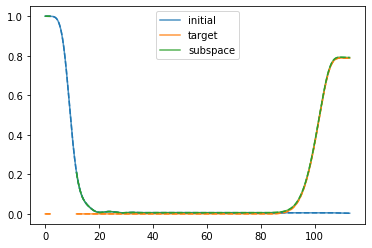

In [31]:
plot_population(pop_data, pop_data_baseline, alpha=0.8)